In [1]:
import os, math, colorsys
import numpy as np
import tifffile as tiff
from scipy.ndimage import gaussian_filter1d
from skimage import exposure
import imageio.v3 as iio
import matplotlib.pyplot as plt

def robust_std(x, axis=0):
    """MAD → robust SD per-pixel."""
    med = np.nanmedian(x, axis=axis)
    mad = np.nanmedian(np.abs(x - np.expand_dims(med, axis)), axis=axis)
    return 1.4826 * mad

def first_crossing_with_hold(x, thr, hold=3):
    """
    x: (T,) 1D signal
    thr: threshold
    hold: must remain >= thr for 'hold' consecutive frames
    return onset index or -1
    """
    above = x >= thr
    if hold <= 1:
        idx = np.argmax(above)
        return int(idx) if above.any() else -1
    count = 0
    for i, a in enumerate(above):
        count = count + 1 if a else 0
        if count == hold:
            return i - hold + 1
    return -1

def hsv_to_rgb_image(h, s, v):
    """Elementwise HSV→RGB for arrays in [0,1], returns float32 RGB [0,1]."""
    hsv = np.stack([h, s, v], axis=-1)
    flat = hsv.reshape(-1, 3)
    out = np.empty_like(flat, dtype=np.float32)
    for i, (hh, ss, vv) in enumerate(flat):
        r, g, b = colorsys.hsv_to_rgb(float(hh), float(ss), float(vv))
        out[i] = (r, g, b)
    return out.reshape((*h.shape, 3)).astype(np.float32)


In [7]:

tiff_path       = r"C:\Maha\DATA\electric_stim\vsx2\vsx2_imaging\F2_t2.tif"  # <--- change to your file
out_prefix      = os.path.splitext(os.path.basename(tiff_path))[0]

stim_frame      = 98 #288     # 0-based frame index
fps             = 4.9 #9.6      # frames per second (1 frame ≈ 0.10417 s)
prestim_frames  = 50     # baseline window (frames) immediately before stim

# Detection / visualization
gauss_sigma     = 1.0      # temporal smoothing (frames), 0 = off
thr_sd          = 2.5    # threshold = thr_sd × robust_SD(pre-stim ΔF/F)
min_duration    = 3        # consecutive frames above threshold to confirm onset
poststim_window = 10  # seconds after stim to search for onset (set <=0 for all remaining)
max_dff_window  = 1.0      # seconds around onset to measure peak ΔF/F for brightness
make_overlay    = True     # also blend the color map on mean image

# Repro/printing
np.set_printoptions(suppress=True)


In [8]:
# Load stack (expects T x Y x X)
stack = tiff.imread(tiff_path)
if stack.ndim != 3:
    raise ValueError(f"Expected (T,Y,X) stack; got shape {stack.shape}")

stack = stack.astype(np.float32)
T, Y, X = stack.shape
print(f"Loaded stack: T={T}, Y={Y}, X={X}")

# Pre-stim baseline frames
if stim_frame < 2:
    raise ValueError("stim_frame must be ≥ 2 to compute a baseline.")

pre1 = stim_frame
pre0 = max(0, pre1 - prestim_frames)
pre_stack = stack[pre0:pre1]  # (P, Y, X)

# Baseline F0 (median for robustness) and ΔF/F
F0 = np.median(pre_stack, axis=0).astype(np.float32)
F0[F0 < 1e-6] = 1e-6
dff = (stack - F0) / F0

# Optional temporal smoothing (helps at low SNR)
if gauss_sigma and gauss_sigma > 0:
    dff = gaussian_filter1d(dff, sigma=gauss_sigma, axis=0, mode="nearest")

print("ΔF/F computed.")



Loaded stack: T=300, Y=1024, X=1024
ΔF/F computed.


In [9]:
# Robust noise estimate from pre-stim ΔF/F
noise_sd = robust_std(dff[pre0:pre1], axis=0).astype(np.float32)
noise_sd[noise_sd < 1e-6] = 1e-6
thr = thr_sd * noise_sd  # (Y, X)

# Time windows (frames)
post_frames = int(round(poststim_window * fps)) if poststim_window > 0 else (T - stim_frame - 1)
post_frames = max(1, min(post_frames, T - stim_frame - 1))
maxwin_frames = max(1, int(round(max_dff_window * fps)))

t_lo = stim_frame
t_hi = min(T, stim_frame + 1 + post_frames)

onset_map  = np.full((Y, X), -1, dtype=np.int32)     # first activation frame, -1 if none
dffmax_map = np.zeros((Y, X), dtype=np.float32)      # peak ΔF/F near onset

# Loop over pixels (robust and clear; typical sizes run fast)
for y in range(Y):
    sig = dff[:, y, :]          # (T, X)
    thr_row = thr[y, :]
    for x in range(X):
        trace = sig[t_lo:t_hi, x]
        idx = first_crossing_with_hold(trace, thr_row[x], hold=min_duration)
        if idx >= 0:
            onset = t_lo + idx
            onset_map[y, x] = onset
            lo = max(stim_frame, onset - maxwin_frames//2)
            hi = min(T, onset + maxwin_frames//2 + 1)
            dffmax_map[y, x] = float(np.nanmax(dff[lo:hi, y, x]))

valid = onset_map >= 0
n_valid = int(valid.sum())
print(f"Detected onsets in {n_valid}/{Y*X} pixels ({100*n_valid/(Y*X+1e-9):.2f}%).")

if n_valid:
    onset_min = int(np.min(onset_map[valid]))
    onset_max = int(np.max(onset_map[valid]))
    earliest_ms = (onset_min - stim_frame) * 1000.0 / fps
    latest_ms   = (onset_max - stim_frame) * 1000.0 / fps
    print(f"Earliest onset: frame {onset_min} ({earliest_ms:.1f} ms after stim)")
    print(f"Latest onset:   frame {onset_max} ({latest_ms:.1f} ms after stim)")


Detected onsets in 86031/1048576 pixels (8.20%).
Earliest onset: frame 98 (0.0 ms after stim)
Latest onset:   frame 145 (9591.8 ms after stim)


C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_25168\973547775.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap    = cm.get_cmap(PALETTE)


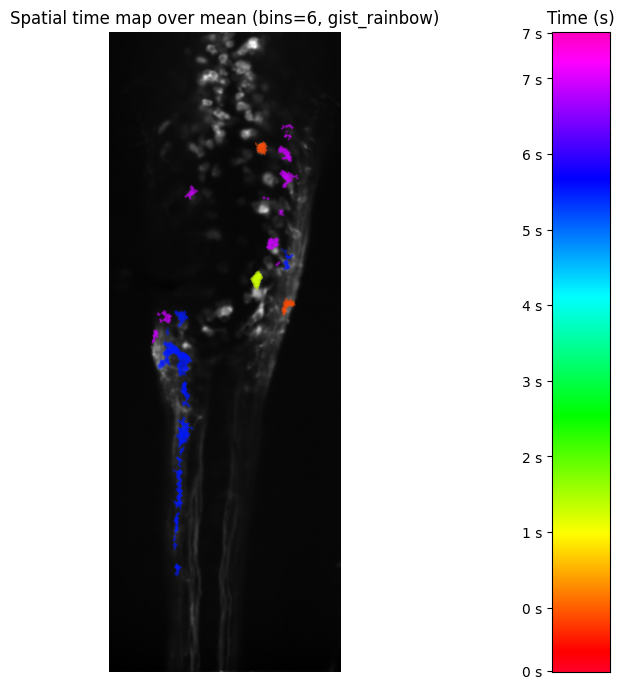

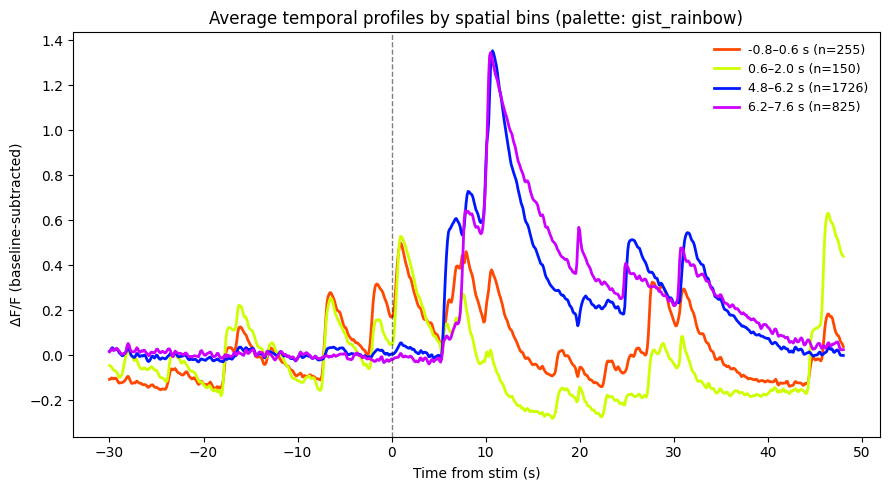

✅ Saved spatial overlay to: concatenate_spatial_overlay.svg
✅ Saved temporal traces to: concatenate_temporal_traces.svg


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.ndimage import gaussian_filter1d
from skimage import exposure

# =================== OPTIONS ===================
PALETTE   = "gist_rainbow"   # must match the spatial color scheme you want
N_BINS    = 6           # number of time bins
MIN_PIX   = 20          # skip bins with fewer pixels than this
SMOOTH_SD = 0.0         # smooth traces (in frames); 0 = off
BASELINE_PRE = True     # subtract pre0:pre1 baseline if available
ALPHA_OVERLAY = 0.65    # fallback overlay alpha if no ΔF/F map available
# ===============================================

# ---------- Resolve outputs ----------
out_prefix_safe = globals().get("out_prefix", "temporal")
spatial_svg = f"{out_prefix_safe}_spatial_overlay.svg"
traces_svg  = f"{out_prefix_safe}_temporal_traces.svg"

# ---------- Denoised mask used for both spatial & traces ----------
if 'act' in globals():
    den_mask = (act.astype(bool) & (onset_map >= stim_frame))
elif 'mask_clean' in globals():
    den_mask = (mask_clean.astype(bool) & (onset_map >= stim_frame))
else:
    den_mask = (onset_map >= stim_frame)

if not np.any(den_mask):
    raise ValueError("No pixels in the post-stim denoised mask. Check your denoising step.")

T, Y, X = dff.shape

# ---------- Use EXACT same hue normalization as overlay (rebuild if needed) ----------
if 'hue' in globals() and 'f0' in globals() and 'f1' in globals():
    f0_use, f1_use = int(f0), int(f1)
    hue_use = hue.copy()
    hue_use[~den_mask] = np.nan
else:
    f0_use = max(stim_frame, int(np.min(onset_map[den_mask])))
    f1_use = int(np.max(onset_map[den_mask])); f1_use = max(f1_use, f0_use + 1)
    hue_use = (onset_map - f0_use) / float(f1_use - f0_use)
    hue_use = np.clip(hue_use, 0, 1).astype(np.float32)
    hue_use[~den_mask] = np.nan

# ---------- Build time bins and colors (EXACT matches for spatial+traces) ----------
edges   = np.linspace(0.0, 1.0, N_BINS + 1)
centers = 0.5 * (edges[:-1] + edges[1:])
cmap    = cm.get_cmap(PALETTE)
bin_colors = cmap(centers)[..., :3]  # RGB [0..1]

# Seconds labels for bins (matching legend)
t0_s = (f0_use - stim_frame) / float(fps)
t1_s = (f1_use - stim_frame) / float(fps)
bin_start_s = t0_s + edges[:-1] * (t1_s - t0_s)
bin_end_s   = t0_s + edges[1:]  * (t1_s - t0_s)

# ---------- Quantize spatial map to bin colors ----------
h_valid = np.isfinite(hue_use)
bin_idx = np.digitize(hue_use, edges, right=False) - 1
bin_idx[~h_valid] = -1
bin_idx[bin_idx == N_BINS] = N_BINS - 1

quant_rgb = np.zeros((Y, X, 3), dtype=np.float32)
for b in range(N_BINS):
    quant_rgb[bin_idx == b] = bin_colors[b]

# ---------- Overlay mean reference image on the quantized map ----------
mean_img  = np.mean(stack, axis=0).astype(np.float32)
mean_norm = exposure.rescale_intensity(mean_img, in_range="image", out_range=(0, 1))
base_rgb  = np.repeat(mean_norm[..., None], 3, axis=2)

# Prefer a ΔF/F-based alpha if available (v_clean/v_smooth/v_work/dffmax_map), else constant alpha
if 'v_clean' in globals():
    v_alpha = np.asarray(v_clean, np.float32)
elif 'v_smooth' in globals():
    v_alpha = np.asarray(v_smooth, np.float32)
elif 'v_work' in globals():
    v_alpha = np.asarray(v_work, np.float32)
elif 'dffmax_map' in globals():
    vals = (dffmax_map[den_mask]).astype(np.float32)
    lo, hi = (0.0, 1.0) if vals.size == 0 else np.percentile(vals, [2, 98])
    hi = lo + 1e-6 if hi <= lo else hi
    v_alpha = np.clip((dffmax_map.astype(np.float32) - lo) / (hi - lo), 0, 1)
else:
    v_alpha = np.zeros((Y, X), dtype=np.float32)
    v_alpha[den_mask] = ALPHA_OVERLAY

v_alpha = np.clip(v_alpha, 0, 1)
v_alpha[~den_mask] = 0.0
overlay_rgb = v_alpha[..., None] * quant_rgb + (1 - v_alpha[..., None]) * base_rgb
overlay_u8  = (np.clip(overlay_rgb, 0, 1) * 255).astype(np.uint8)

# ---------- Build vertical legend (seconds) with rounded ticks ----------
legend_h, legend_w = 256, 30
legend_grad = np.linspace(0, 1, legend_h, dtype=np.float32)[:, None]
legend_img = (cmap(legend_grad)[..., :3] * 255).astype(np.uint8)

def nice_ticks_seconds(t0, t1, H):
    tr = max(1e-9, t1 - t0)
    if tr <= 1:   step = 0.25
    elif tr <= 3: step = 0.5
    elif tr <= 10: step = 1
    else:         step = 2
    ticks = np.arange(np.floor(t0/step)*step, np.ceil(t1/step)+step, step)
    ticks = np.clip(ticks, t0, t1)
    pos = (ticks - t0) / (t1 - t0 + 1e-9) * (H - 1)
    labels = [f"{t:.1f} s" if step < 1 else f"{int(t)} s" for t in ticks]
    return pos, labels

tick_pos, tick_labels = nice_ticks_seconds(t0_s, t1_s, legend_h)

# ---------- FIGURE 1: Spatial overlay + legend (SVG) ----------
fig1, ax1 = plt.subplots(1, 2, figsize=(9, 7), gridspec_kw={'width_ratios': [1, 0.06]})
ax1[0].imshow(overlay_u8); ax1[0].axis('off')
ax1[0].set_title(f"Spatial time map over mean (bins={N_BINS}, {PALETTE})")
ax1[1].imshow(legend_img, origin='lower', aspect='auto'); ax1[1].set_xticks([])
ax1[1].set_yticks(tick_pos); ax1[1].set_yticklabels(tick_labels); ax1[1].set_title("Time (s)")
plt.tight_layout()
fig1.savefig(spatial_svg, format="svg")
plt.show()

# ---------- FIGURE 2: Temporal traces with EXACT matching colors (SVG) ----------
# Time axis (seconds relative to stim)
t = (np.arange(T) - stim_frame) / float(fps)

# Optional baseline subtraction window
use_baseline = False
if BASELINE_PRE and 'pre0' in globals() and 'pre1' in globals():
    i_base_lo, i_base_hi = int(pre0), int(pre1)
    i_base_lo = max(0, i_base_lo); i_base_hi = min(T, i_base_hi)
    use_baseline = i_base_hi > i_base_lo

bin_traces, bin_labels, bin_cols = [], [], []
for b in range(N_BINS):
    sel = (bin_idx == b)
    n_pix = int(np.count_nonzero(sel))
    if n_pix < MIN_PIX:
        continue
    trace = np.nanmean(dff[:, sel], axis=1)
    if use_baseline:
        base_val = np.nanmean(trace[i_base_lo:i_base_hi]) if np.isfinite(trace[i_base_lo:i_base_hi]).any() else 0.0
        trace = trace - base_val
    if SMOOTH_SD and SMOOTH_SD > 0:
        trace = gaussian_filter1d(trace, sigma=SMOOTH_SD, mode='nearest')
    bin_traces.append(trace)
    bin_cols.append(bin_colors[b])
    bin_labels.append(f"{bin_start_s[b]:.1f}–{bin_end_s[b]:.1f} s (n={n_pix})")

fig2 = plt.figure(figsize=(9, 5))
for tr, col, lbl in zip(bin_traces, bin_cols, bin_labels):
    plt.plot(t, tr, color=col, linewidth=2, label=lbl)
plt.axvline(0, linestyle='--', linewidth=1, color='k', alpha=0.5)
plt.xlabel("Time from stim (s)")
ylabel = "ΔF/F"
if use_baseline:
    ylabel += " (baseline-subtracted)"
plt.ylabel(ylabel)
plt.title(f"Average temporal profiles by spatial bins (palette: {PALETTE})")
plt.legend(loc="best", fontsize=9, frameon=False)
plt.tight_layout()
fig2.savefig(traces_svg, format="svg")
plt.show()

print(f"✅ Saved spatial overlay to: {spatial_svg}")
print(f"✅ Saved temporal traces to: {traces_svg}")
